In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from pandas import Series, DataFrame
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from IPython.core.pylabtools import figsize

%matplotlib inline
figsize(15, 10)

# Load and adjust the data

In [2]:
df_train = pd.read_csv('../data/TableS2_training.csv', keep_default_na=False)
df_TS3 = pd.read_csv('../data/TableS3_training.csv', keep_default_na=False)

df_TS3['RRF_Measured'] = df_TS3['RRF_Measured'] * 1e-2
df_TS3['RRF_Predicted'] = df_TS3['RRF_Predicted'] * 1e-2

df_train['RRF_Measured'] = df_train['RRF_Measured'] * 1e-2
df_train['RRF_Predicted'] = df_train['RRF_Predicted'] * 1e-2

# Data preparation
- Exclude certain metabolites
- Select training and testing data

In [3]:
features = ['MV', 'logD', 'abs_mob']

# Training Data
X_train = df_train[features]
X_train = X_train[df_train['Annotation'] == '']

y_train = df_train[['RRF_Measured']]
y_train = y_train[df_train['Annotation'] == '']

# Testing Data
X_test = df_TS3[features]
y_test = df_TS3[['RRF_Measured']]

print("Number of metabolites (training):", len(X_train))
print("Number of metabolites (testing):", len(X_test))

Number of metabolites (training): 36
Number of metabolites (testing): 10


# Fit Gaussian Process

In [4]:
model = GPy.models.GPRegression(X_train, y_train, normalizer=True)

model.optimize()

In [5]:
from IPython.display import display
display(model)

# Make predictions

We are making predictions on the same data we used for training, which doesn't seem correct

In [6]:
mu, var = model.predict(X_test.as_matrix())

In [7]:
data = pd.concat([df_TS3, DataFrame(mu, columns=['Prediction'])], axis=1)

data[['Name', 'RRF_Measured', 'Prediction', 'RRF_Predicted']]

,Name,RRF_Measured,Prediction,RRF_Predicted
0,L-Ornithine,0.00281,0.006826,0.00631
1,N-Methyl-Aspartic acid,0.00842,0.008051,0.00667
2,3-Methyl-L-Histidine,0.01400,0.021092,0.02280
3,L-Theanine,0.02320,0.023411,0.02190
4,L-Citrulline,0.01160,0.019378,0.01600
5,O-Propionyl-L-Carnitine,0.05230,0.046295,0.05740
6,L-Carnosine,0.01910,0.030535,0.03030
7,O-Butyryl-L-Carnitine,0.06660,0.065164,0.06030
8,1-Methyl-Adenosine,0.05240,0.058979,0.05110
9,O-Octoyl-L-Carnitine,0.07780,0.085108,0.09750


# Comparison of model metrics

In [8]:
y_true = data['RRF_Measured']
y_pred = data['RRF_Predicted']
y_pred_new = data['Prediction']

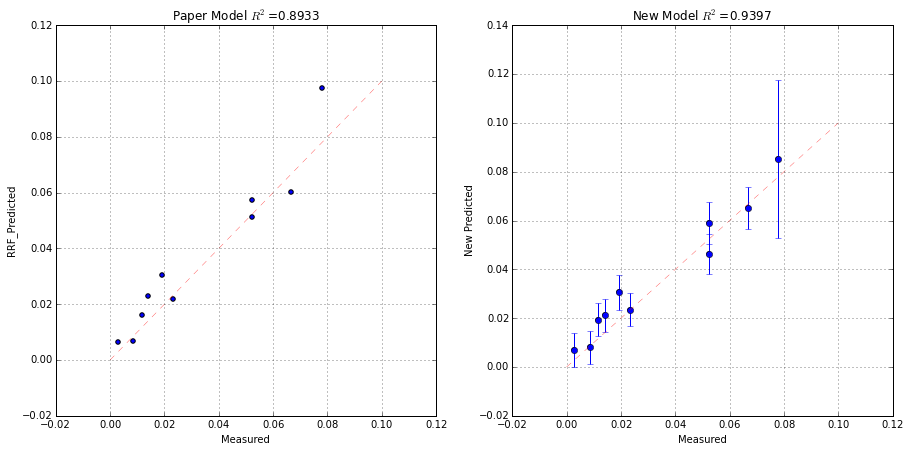

In [9]:
figsize(15, 7)
plt.subplot(1, 2, 1)
plt.xlabel('Measured')
plt.ylabel('RRF_Predicted')
plt.scatter(y_true, y_pred)
plt.plot([0, 0.1], [0, 0.1], 'r--', linewidth=.3)
plt.grid(True)
plt.title('Paper Model $R^2$={:.4f}'.format(r2_score(y_true, y_pred)))

plt.subplot(1, 2, 2)
plt.xlabel('Measured')
plt.ylabel('New Predicted')
plt.scatter(y_true, y_pred_new)
plt.errorbar(y_true, y_pred_new, yerr=np.sqrt(var), fmt='o')
plt.plot([0, 0.1], [0, 0.1], 'r--', linewidth=.3)
plt.grid(True)
plt.title('New Model $R^2$={:.4f}'.format(r2_score(y_true, y_pred_new)))

plt.show()

## Metrics of the model reported in the paper

In [10]:
print("explained_variance", explained_variance_score(y_true, y_pred))
print("mean_absolute_error", mean_absolute_error(y_true, y_pred))
print("r2_score", r2_score(y_true, y_pred))

explained_variance 0.920425066704
mean_absolute_error 0.006335
r2_score 0.893256890472


## Metrics of our model

In [11]:
print("explained_variance", explained_variance_score(y_true, y_pred_new))
print("mean_absolute_error", mean_absolute_error(y_true, y_pred_new))
print("r2_score", r2_score(y_true, y_pred_new))

explained_variance 0.960259872505
mean_absolute_error 0.00522284319772
r2_score 0.939667857796
